In [1]:
import numpy as np
import pandas as pd
import pickle
import csv
import matplotlib.pyplot as plt
from scipy import stats
import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from numpy import linspace, meshgrid
import reverse_geocoder as rg
from scipy.special import inv_boxcox
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from Data import Data
from datetime import datetime
import itertools
from collections import Counter
import pickle
import scipy.stats as stats
import seaborn as sns

In [2]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FactorAnalysis
X, _ = load_digits(return_X_y=True)

In [3]:
transformer = FactorAnalysis(n_components=7, random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

(1797, 7)

In [24]:
X.shape

(1797, 64)

In [23]:
transformer.

<bound method BaseEstimator.get_params of FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=7,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)>

In [25]:
X_transformed

(1797, 7)

In [2]:
def neighbour_average(pre_list,result,lon,lat):
    shift = [[-0.25,0,0.25],[-0.25,0,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    shift_list.remove((0,0))
    r = []
    for x,y in shift_list:
        if (lon + x,lat + y) in pre_list:
            j = pre_list.index((lon + x,lat + y))
            r.append(result.iloc[:,j].values)
        #else:
         #   print("NO")
          #  print(lon + x,lat + y)
           # r.append(np.zeros(817))   
    r = np.array(r)        
    return(np.average(r, axis=0))

In [3]:
def fuzzify(x):
  # Add some "measurement error"" to each data point
    x[x<0]=0
    zero_idx = (x == 0)
    x[zero_idx]+=0.005*np.random.uniform(0,1,1)[0]
    x[~zero_idx]+=0.005*np.random.uniform(-1,1,1)[0]
    return(x)

In [4]:
def BCZT(data):
    lambda_list = []
    n  = data.shape[1]
    N  = data.shape[0]
    data_transformed = np.zeros(data.shape)
    for i in range(n):
        x = fuzzify(data[:,i])
        d_temp, lambda_ = stats.boxcox(x)
        d_temp = (d_temp - d_temp.mean())/d_temp.std()
        data_transformed[:,i] = d_temp
        lambda_list.append(lambda_)
    return(data_transformed, lambda_list)

In [5]:
def PA(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal) 

In [6]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

def removeOutliers_Idx(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)   
    Idx = np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))
    return(Idx)
    
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    outliers = a[np.where((a < quartileSet[0]) | (a > quartileSet[1]))]
    return(result.tolist(), outliers.tolist())

def studentT_test(first_var, second_var):
    n_1 = len(first_var)
    mean_1 = np.mean(first_var)
    var_1 = np.var(first_var)
    
    n_2 = len(second_var)
    mean_2 = np.mean(second_var)
    var_2 = np.var(second_var)
    
    d_f = min(n_1 - 1, n_2 - 1)
    
    t_test = (mean_1 - mean_2) /math.sqrt(var_1/n_1 + var_2/n_2) 
    p_value = 1 - stats.t.cdf(t_test, d_f)
    
    return(t_test, p_value, n_1, n_2)

def studentT_test_one(var, h_mean = 0):
    n = len(var)
    mean = np.mean(var)
    std = np.std(var)

    t_test = (mean - h_mean) / (std/math.sqrt(n)) 
    p_value = 1 - stats.t.cdf(t_test, n - 1)
    
    return(t_test, p_value)

In [7]:
EPA = pd.read_csv("../results/EPA.csv")
APA = pd.read_csv("../results/APA.csv")
ABCZT = pd.read_csv("../results/ABCZTTemp.csv")
EBCZT = pd.read_csv("../results/EBCZT.csv")
EBC = pd.read_csv("../results/EBC.csv")
ABC = pd.read_csv("../results/ABCTemp.csv")
EBCPA = pd.read_csv("../results/EBCPA.csv")
ABCPA = pd.read_csv("../results/ABCPATemp.csv")
A = pd.read_csv("../results/ATemp.csv")
E = pd.read_csv("../results/E.csv")
ES = pd.read_csv("../results/ES.csv")
EBCS = pd.read_csv("../results/EBCS.csv")
AC = pd.read_csv("../results/AC.csv")
AS = pd.read_csv("../results/AS.csv")
PROAPA = pd.read_csv("../results/PROAPA.csv")

temp = A["lon"].values
temp[temp > 180] = temp[temp > 180] -360
A["lon"] = temp

temp = E["lon"].values
temp[temp > 180] = temp[temp > 180] -360
E["lon"] = temp

temp = APA["lon"].values
temp[temp > 180] = temp[temp > 180] -360
APA["lon"] = temp

temp = EPA["lon"].values
temp[temp > 180] = temp[temp > 180] -360
EPA["lon"] = temp

temp = ES["lon"].values
temp[temp > 180] = temp[temp > 180] -360
ES["lon"] = temp

temp = EBCS["lon"].values
temp[temp > 180] = temp[temp > 180] -360
EBCS["lon"] = temp

temp = ABCZT["lon"].values
temp[temp > 180] = temp[temp > 180] -360
ABCZT["lon"] = temp

temp = EBCZT["lon"].values
temp[temp > 180] = temp[temp > 180] -360
EBCZT["lon"] = temp

temp = ABC["lon"].values
temp[temp > 180] = temp[temp > 180] -360
ABC["lon"] = temp

temp = EBC["lon"].values
temp[temp > 180] = temp[temp > 180] -360
EBC["lon"] = temp

temp = ABCPA["lon"].values
temp[temp > 180] = temp[temp > 180] -360
ABCPA["lon"] = temp

temp = EBCPA["lon"].values
temp[temp > 180] = temp[temp > 180] -360
EBCPA["lon"] = temp

temp = AS["lon"].values
temp[temp > 180] = temp[temp > 180] -360
AS["lon"] = temp

temp = AC["lon"].values
temp[temp > 180] = temp[temp > 180] -360
AC["lon"] = temp

temp = PROAPA["lon"].values
temp[temp > 180] = temp[temp > 180] -360
PROAPA["lon"] = temp

In [8]:
ES_error = ES["meanRME"].values
APA_error = APA["meanRME"].values
EPA_error = EPA["meanRME"].values
EBCZT_error = EBCZT["meanRME"].values
EBC_error = EBC["meanRME"].values
EBCPA_error = EBCPA["meanRME"].values
ABC_error = ABC["meanRME"].values
ABCZT_error = ABCZT["meanRME"].values
A_error = A["meanRME"].values
E_error = E["meanRME"].values
ABCPA_error = ABCPA["meanRME"].values
EBCS_error = EBCS["meanRME"].values
AS_error = AS["meanRME"].values
AC_error = AC["meanRME"].values
PROAPA_error = PROAPA["meanRME"].values

In [9]:
ES_error, _ = removeOutliers(ES_error, 1.5)
         

APA_error, _ = removeOutliers(APA_error, 1.5)
        

EPA_error, _ = removeOutliers(EPA_error, 1.5)
        

EBCZT_error, _ = removeOutliers(EBCZT_error, 1.5)


EBC_error, _ = removeOutliers(EBC_error, 1.5)


EBCPA_error, _ = removeOutliers(EBCPA_error, 1.5)


ABC_error, _ = removeOutliers(ABC_error, 1.5)


ABCZT_error, _ = removeOutliers(ABCZT_error, 1.5)


A_error, _ = removeOutliers(A_error, 1.5)


E_error, _ = removeOutliers(E_error, 1.5)


ABCPA_error, _ = removeOutliers(ABCPA_error, 1.5)

EBCS_error, _ = removeOutliers(EBCS_error, 1.5)

AS_error, _ = removeOutliers(AS_error, 1.5)

AC_error, _ = removeOutliers(AC_error, 1.5)

PROAPA_error, _ = removeOutliers(PROAPA_error, 1.5)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


In [11]:
stats.f_oneway(PROAPA_error, APA_error, EPA_error, EBCZT_error, EBC_error, ABC_error, ABCZT_error)

F_onewayResult(statistic=126.99346137942555, pvalue=7.949317310586467e-148)

In [15]:
stats.ttest_ind(PROAPA_error,EBC_error)

Ttest_indResult(statistic=-3.13456072549495, pvalue=0.0017633656524573362)

In [14]:
np.count_nonzero(APA_error >= PROAPA_error)/len(APA_error)

0.5937007874015748

In [10]:
studentT_test(APA_error, PROAPA_error)

(0.3867932892016408, 0.3495231935367389, 602, 601)

In [58]:
studentT_test_one(np.array(APA_error) - np.array(PROAPA_error))

(3.716496461878702, 0.0001099281392659135)

In [59]:
r  = np.array(APA_error) - np.array(PROAPA_error)

In [61]:
r.mean()

0.23944424965392883

In [51]:
np.mean(APA_error)

24.0150892898527

In [52]:
np.mean(PROAPA_error)

23.673183816823677

In [69]:
studentT_test_one(EBCPA_error - EPA_error)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

AttributeError: 'Rectangle' object has no property 'normed'

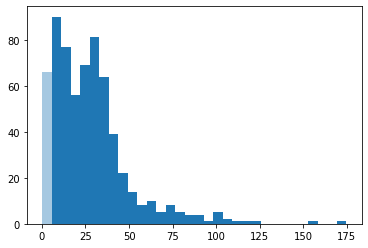

In [39]:
sns.distplot(PROAPA_error)

AttributeError: 'Rectangle' object has no property 'normed'

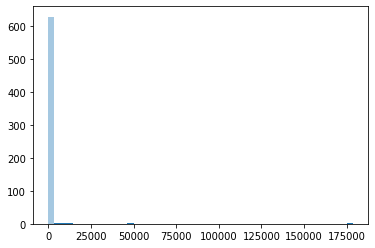

In [41]:
sns.distplot(EBCZT_error)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


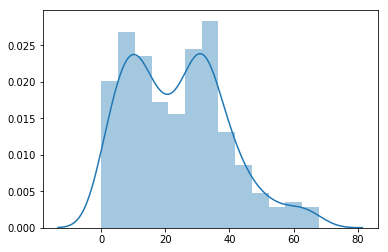

In [26]:
sns.distplot(APA_error)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


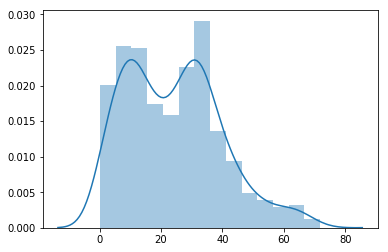

In [27]:
sns.distplot(EPA_error)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


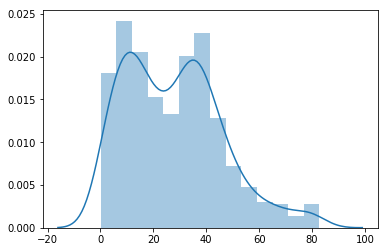

In [34]:
sns.distplot(A_error)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


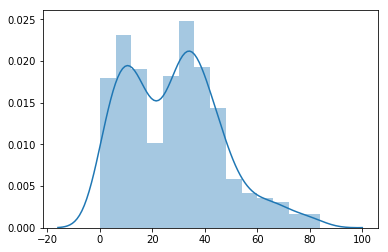

In [35]:
sns.distplot(E_error)

In [82]:
df = pd.DataFrame()

In [98]:
error = np.concatenate((APA_error , EPA_error , A_error , E_error , PROAPA_error))

In [99]:
group = ['APA']*len(APA_error) + ['EPA']*len(EPA_error)+  ['A']*len(A_error) +['E']*len(E_error)  + ['PROAPA']*len(PROAPA_error)

In [100]:
df['group'] = group

In [101]:
df['error'] = error

In [103]:
df.to_csv('error1.csv')

In [68]:
df = pd.DataFrame()

In [48]:
#df["group"] = np.repeat('ES',len(ES_error))

In [69]:
error = ES_error + APA_error + EPA_error + EBCZT_error + EBC_error + EBCPA_error + ABC_error + ABCZT_error + A_error + E_error + ABCPA_error + EBCS_error + AC_error + AS_error + PROAPA_error

In [71]:
group = ['ES']*len(ES_error) + ['APA']*len(APA_error) + ['EPA']*len(EPA_error) + ['EBCZT']*len(EBCZT_error) + ['EBC']*len(EBC_error) + ['EBCPA']*len(EBCPA_error) + ['ABC']*len(ABC_error) + ['ABCZT']*len(ABCZT_error) + ['A']*len(A_error) +['E']*len(E_error) + ['ABCPA']*len(ABCPA_error) + ['EBCS']*len(EBCS_error) + ['AS']*len(AS_error) + ['AC']*len(AC_error) + ['PROAPA']*len(PROAPA_error) 
#group = ['ES']*len(ES_error) + ['APA']*len(APA_error) + ['EPA']*len(EPA_error) + ['EBC']*len(EBC_error) + ['EBCZT']*len(EBCZT_error)

In [72]:
df['group'] = group

In [73]:
df['error'] = error

ValueError: Length of values does not match length of index

In [19]:
df.to_csv('error.csv')

,Unnamed: 0,i,j,lon,lat,ES,APA,EPA,EBCZT,EBC
0,1,1,10,-23.75,16.25,18.623355,18.039587,17.973828,18.552883,18.454289
1,2,1,11,-23.75,13.75,32.449106,32.036228,32.009613,33.415118,33.479207
2,3,3,5,-18.75,28.75,47.637431,43.832395,43.751354,47.374384,49.858414
3,4,3,11,-18.75,13.75,37.272560,36.389430,36.823538,37.650293,37.518786
4,5,4,3,-16.25,33.75,100.708589,97.492038,96.896130,103.252947,105.382580
...,...,...,...,...,...,...,...,...,...,...
630,631,34,8,58.75,21.25,13.863802,12.348884,12.248460,15.247478,13.676208
631,632,34,9,58.75,18.75,7.970843,8.044364,8.102928,199.220324,41.519087
632,633,34,23,58.75,-16.25,69.317178,66.292945,66.799086,71.163694,71.204023
633,634,34,24,58.75,-18.75,102.094962,99.831195,99.915454,143.189600,142.467342


In [15]:
def class_finder(data):
    climate_class = []
    for i in range(len(data)):  
        if data["lon"][i] < 180:
            lon_key = data["lon"][i] 
        else:
            lon_key = -(360 - data["lon"][i])   
        lat_key = data["lat"][i] 
        if (lat_key,lon_key) in class_dic.keys():
            climate_class.append(class_dic[(lat_key,lon_key)])
        else:
            climate_class.append("None")
    data["class"] = climate_class


In [21]:
class_finder(PROAPA)

In [60]:
class_id = 'Am'

In [61]:
a = PROAPA[PROAPA["class"] == class_id]

In [62]:
b = APA[APA["class"] == class_id]

In [63]:
np.count_nonzero(a["meanRME"] < b["meanRME"])/len(a)

0.5

In [39]:
set(PROAPA["class"])

{'Af',
 'Am',
 'As',
 'Aw',
 'BSh',
 'BSk',
 'BWh',
 'BWk',
 'Cfa',
 'Cfb',
 'Csa',
 'Csb',
 'Cwa',
 'Cwb',
 'Dsa',
 'Dsb',
 'None'}

In [13]:
ABC = ABC.reset_index()

In [14]:
ABC = ABC.drop(columns=['index'])

In [49]:
class_finder(EBC)

In [43]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [44]:
classes = set(EPA["class"])

In [16]:
def compare(first, second):
    item_class = []
    p_values = []
    t = []
    significant = []
    number = []
    for item in classes:
        if item != "None":

            first_error = first.loc[first['class'] == item]["meanRME"]
            #ets_error = removeOutliers(ets_error, 1.5)

            second_error = second.loc[second['class'] == item]["meanRME"]
            #stl_error = removeOutliers(stl_error, 1.5)

            #EPA_error = EPA.loc[EPA['class'] == item]["meanErrorRatio"]
            #auto_error = removeOutliers(auto_error, 1.5)

           # EBCZT_error = EBCZT.loc[EBCZT['class'] == item]["meanErrorRatio"]
            #NN_error = removeOutliers(NN_error, 1.5)


            t_test, p_value, n_auto, n_NN = studentT_test(first_error, second_error) 

            item_class.append(item)
            t.append(t_test)
            number.append(n_NN)
            significant.append(p_value < 0.05)      
            p_values.append(p_value)
    result = pd.DataFrame({"classes":item_class,"t test":t, "p_values":p_values, "95% significant": significant, "number":number})
    return(result)

In [24]:
compare(APA,ABC)

,classes,t test,p_values,95% significant,number
0,Am,-1.4171,0.9079,False,12
1,Cfa,-1.0311,0.7946,False,3
2,BWk,-3.0933,0.9953,False,13
3,Cwb,-3.2948,0.9917,False,7
4,Cfb,-0.7527,0.7468,False,4
5,Dsb,-6.1547,0.9957,False,4
6,Csb,-1.5013,0.8849,False,4
7,Af,-0.7536,0.7602,False,7
8,BSh,-1.0069,0.8413,False,73
9,BWh,-1.4286,0.9227,False,222


In [12]:
def class_compare(data):
    item_class = []
    meanRSME = []
    meanMAE = []
    meanRSMERatio = []
    number = []
    for item in classes:
        if item != "None":

            RSME = data.loc[data['class'] == item]["meanRME"].values
            MAE = data.loc[data['class'] == item]["meanMAE"].values
            RSMERatio = data.loc[data['class'] == item]["meanErrorRatio"].values
        

            item_class.append(item)
            meanRSME.append(RSME.mean())
            meanMAE.append(MAE.mean())
            meanRSMERatio.append(RSMERatio.mean())      
            
    result = pd.DataFrame({"classes":item_class,"RSME":meanRSME, "MAE":meanMAE, "RSMERatio": meanRSMERatio})
    return(result)

In [88]:
a = ES.loc[ES['class'] == "Cwa"]["meanRME"].values

In [47]:
class_compare(ABC)

,classes,RSME,MAE,RSMERatio
0,Am,64.8292,48.0602,0.3992
1,Cfa,59.2331,44.7335,0.8274
2,BWk,22.0472,13.1781,2.9867
3,Cwb,63.8157,43.7368,0.8954
4,Cfb,54.5876,39.6932,0.6286
5,Dsb,24.8289,18.7268,0.6669
6,Csb,46.1111,30.6607,1.5244
7,Af,48.8512,36.9768,0.3170
8,BSh,17745267621998230.0000,4071043594236516.0000,266840557098969.4688
9,BWh,273692.9901,89916.4694,30329.9534


In [50]:
class_compare(EBC)

,classes,RSME,MAE,RSMERatio
0,Am,44.7587,32.8632,0.2897
1,Cfa,47.9495,33.0770,0.6722
2,BWk,13.0954,7.4232,1.1601
3,Cwb,35.4758,24.2723,0.5011
4,Cfb,43.3497,30.6751,0.5242
5,Dsb,20.6216,14.8979,0.5457
6,Csb,24.5197,15.9409,0.7799
7,Af,41.2421,31.1355,0.2661
8,BSh,39.7886,21.7039,0.9095
9,BWh,1646.1735,292.5322,nan


In [77]:
class_compare(ES)

,classes,RSME,MAE,RSMERatio
0,Aw,38.338565,26.904119,0.388691
1,Csb,24.107679,17.060346,0.772016
2,Csa,33.067794,24.014764,0.735762
3,BSk,20.868241,15.357682,0.795524
4,As,43.580472,31.334282,0.788455
5,Cfb,42.799366,31.335901,0.509197
6,Af,40.462753,31.129349,0.261826
7,Cfa,46.411090,34.526361,0.650849
8,Am,43.782758,32.468490,0.285910
9,BWk,12.945809,8.492672,1.170035


In [125]:
class_compare(EBCZT)

,classes,RSME,MAE,RSMERatio
0,Csb,24.7691,16.1182,0.7905
1,BSh,344.4520,119.9407,10.7330
2,Cwb,35.6937,24.4418,0.5032
3,BWh,850.2643,150.4938,591.3196
4,BSk,21.2058,14.3614,0.8026
5,BWk,13.1153,7.4450,1.1635
6,Dsa,28.7951,19.4830,0.5960
7,Aw,46.9092,28.7772,0.4487
8,Am,44.5004,32.5432,0.2884
9,As,43.0248,27.9356,0.7639


In [99]:
EBCZT.loc[EBCZT['class'] == "BWh"]["meanErrorRatio"].values

array([2.04313652e+00, 1.60371436e+00, 1.17384842e+00, 1.58085824e+00,
       1.82866606e+00, 2.40586538e+00, 1.84920111e+00, 1.28120563e+00,
       1.03380481e+00, 1.68508794e+00, 1.93618457e+00, 2.59399246e+00,
       1.84217906e+00, 1.37243451e+00, 1.02702907e+00, 1.63024359e+00,
       2.38800093e+00, 2.32419640e+00, 1.63072777e+00, 1.36804032e+00,
       8.47683478e-01, 1.57164722e+00, 2.67525970e+00, 2.16080946e+00,
       1.72625870e+00, 1.60145479e+00, 8.30096548e-01, 1.44940389e+00,
       1.84391689e+00, 2.27285820e+00, 1.49095532e+00, 1.67962106e+00,
       1.87959894e+00, 7.68257263e-01, 1.39104963e+00, 2.33558519e+00,
       2.64238869e+00, 2.21713991e+00, 1.79505044e+00, 1.12871701e+00,
       9.76119633e-01, 1.19347106e+00, 2.23759396e+00, 2.54011985e+00,
       2.19313947e+00, 1.79691988e+00, 9.79047673e-01, 7.38732050e-01,
       1.01518978e+00, 1.61908168e+00, 2.04049147e+00, 1.66026385e+00,
       5.74173287e+00, 1.52612185e+00, 9.02299874e-01, 9.74700496e-01,
      

In [16]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

lat_number = len(lat)
lon_number = len(lon)

In [2]:
d = Data('air_monthly_mean_africa.nc','air', missing_value=-9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

In [3]:
temporal_limits = {"time_min":datetime(1948, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [4]:
air_list = list(zip(lon_list_air,lat_list_air))
pre_list = list(zip(lon_list,lat_list))

clean_list = []
Idx = []
for i in range(len(air_list)):
    temp = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])
    if temp.shape:
        clean_list.append(temp)
        Idx.append(i)

NameError: name 'neighbour_average' is not defined

In [374]:
precipitation = np.array(clean_list)
precipitation = pd.DataFrame(np.transpose(precipitation))

result_air = pd.DataFrame(result_air)
temperature = result_air.iloc[:,Idx]

#temperature = temperature/temperature.stack().std()

#precipitation.columns = temperature.columns

#combined_vertically = pd.concat([temperature,precipitation],ignore_index=True,sort=False, axis=0)

In [6]:
dic = rg.search(air_list)

Loading formatted geocoded file...


In [12]:
dic

[OrderedDict([('lat', '78.22334'),
              ('lon', '15.64689'),
              ('name', 'Longyearbyen'),
              ('admin1', 'Svalbard'),
              ('admin2', 'Spitsbergen'),
              ('cc', 'SJ')]),
 OrderedDict([('lat', '78.22334'),
              ('lon', '15.64689'),
              ('name', 'Longyearbyen'),
              ('admin1', 'Svalbard'),
              ('admin2', 'Spitsbergen'),
              ('cc', 'SJ')]),
 OrderedDict([('lat', '78.22334'),
              ('lon', '15.64689'),
              ('name', 'Longyearbyen'),
              ('admin1', 'Svalbard'),
              ('admin2', 'Spitsbergen'),
              ('cc', 'SJ')]),
 OrderedDict([('lat', '78.22334'),
              ('lon', '15.64689'),
              ('name', 'Longyearbyen'),
              ('admin1', 'Svalbard'),
              ('admin2', 'Spitsbergen'),
              ('cc', 'SJ')]),
 OrderedDict([('lat', '78.22334'),
              ('lon', '15.64689'),
              ('name', 'Longyearbyen'),
              

In [7]:
country = []
for i in range(len(air_list)):
    country.append(dic[i].get('cc'))        

In [8]:
country = np.array(country)

In [9]:
ET_index = np.where(country == 'ET')[0]

In [10]:
ET_index

array([462, 463, 464, 495, 496, 497, 528, 529, 530, 561, 562])

In [379]:
temperature_et = temperature.iloc[:,ET_index]

In [380]:
precipitation_et = precipitation.iloc[:,ET_index]

In [381]:
temperature_et_np = temperature_et.values
precipitation_et_np = precipitation_et.values

In [382]:
temperature_et_np = PA(temperature_et_np)

In [384]:
precipitation_et_np = PA(precipitation_et_np)

In [385]:
temperature_et = pd.DataFrame(temperature_et_np)

In [386]:
temperature_et = -temperature_et

In [387]:
precipitation_et = pd.DataFrame(precipitation_et_np)

In [388]:
combined_horizontally = pd.concat([temperature_et,precipitation_et],ignore_index=True,sort=False, axis=1)

In [389]:
combined_horizontally

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.368360,-0.069988,-0.197407,1.020117,1.789737,2.523133,-1.230096,-1.329193,-1.108906,-0.472303,...,-0.663285,-0.533420,-0.170118,-0.137750,-0.004314,-1.030659,-0.087050,0.081352,-0.148712,0.004136
1,0.516025,0.443174,0.792157,-0.379948,-0.602520,-0.524525,-1.764746,-1.433863,-1.017337,-1.670499,...,-0.661033,-0.351143,-0.087284,-0.178862,-0.082043,-0.312453,0.856134,0.026373,0.010325,0.000386
2,0.814788,1.162068,1.165309,-0.572141,-0.133845,0.593690,-0.472949,0.001553,0.693139,-0.627213,...,-0.672540,-0.536380,0.050852,-0.062342,-0.022744,-0.965474,-1.402733,0.141094,-0.044434,-0.030233
3,0.862150,1.459459,1.623068,-0.579992,-0.110036,0.296277,0.656050,1.461082,1.515330,-0.416010,...,-1.046484,-0.269286,-0.029633,-0.071010,0.014064,-0.977900,0.058863,-0.174684,-0.190210,-0.058298
4,-0.089208,0.550653,0.845567,1.185484,0.789981,0.197541,-2.415495,-1.525376,-0.061444,-0.039875,...,-0.168062,0.166078,-0.163488,-0.232146,-0.149196,-0.848580,-1.008715,0.065193,-0.153672,-0.295112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,-0.797170,-1.136126,-1.070490,-1.383540,-1.292821,-0.310551,-1.104843,-0.621442,-0.315669,0.014111,...,-0.540316,2.223548,-0.267789,-0.203886,-0.375817,-0.411290,-1.250077,1.884069,0.341303,0.564056
813,-1.939462,-1.961607,-1.462629,-2.467092,-2.129497,-2.152120,0.366687,-0.889540,-1.417139,-1.538068,...,0.023591,-0.098267,-0.225732,-0.264649,-0.415755,0.944423,2.094039,2.235284,0.616696,-0.478330
814,-1.100338,-1.805926,-1.510063,-0.844940,-1.320721,-1.580279,0.045309,0.218661,0.662871,-0.970471,...,1.338570,1.600031,0.555664,-0.284681,-0.252747,-0.250974,-0.437405,0.558817,-0.515485,0.109471
815,-1.052909,-1.593227,-1.586523,0.670488,0.360339,-0.732352,0.337085,0.749454,0.749660,0.131693,...,-0.875454,-0.792080,0.936456,-0.176550,-0.154303,0.753599,-0.100691,-0.179893,-0.468229,0.608764


In [390]:
pca = PCA(n_components=3)
pca_model = pca.fit(combined_horizontally)

In [391]:
pca_data = pca_model.transform(combined_horizontally)

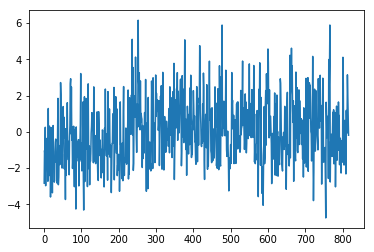

In [393]:
plt.plot(pca_data[:,1])

In [394]:
date_rng = pd.date_range(start='1/1/1948', end='2/1/2016', freq='M')

df = pd.DataFrame(date_rng, columns=['date'])

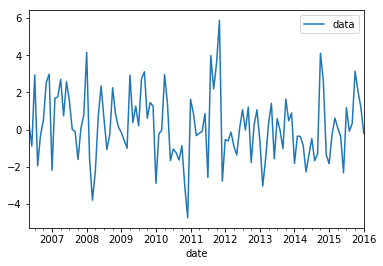

In [402]:
df["data"] = pca_data[:,1]

df1 = df.iloc[700:]

df1.plot(x="date", y="data")

In [4]:
Idx = removeOutliers_Idx(APA.meanError,1.5)[0]
NN = NN.iloc[Idx,:]

Idx = removeOutliers_Idx(stl.meanError,1.5)[0]
stl = stl.iloc[Idx,:]


AttributeError: 'DataFrame' object has no attribute 'meanError'

In [26]:
APA.meanErrorRatio.idxmax()

360

In [27]:
APA.iloc[360,:]

Unnamed: 0        361.000000
i                  22.000000
j                   8.000000
lon                28.750000
lat                21.250000
meanRME             0.898964
meanMAE             0.336607
meanErrorRatio      6.199005
Name: 360, dtype: float64

In [15]:
APA.iloc[25,:]

Unnamed: 0        26.000000
i                  5.000000
j                 31.000000
lon              -13.750000
lat              -36.250000
meanRME            6.521026
meanMAE            4.916532
meanErrorRatio     0.048642
Name: 25, dtype: float64

In [28]:
APA.sort_values(by=['meanErrorRatio'])

,Unnamed: 0,i,j,lon,lat,meanRME,meanMAE,meanErrorRatio
25,26,5,31,-13.75,-36.25,6.521026,4.916532,0.048642
36,37,6,31,-11.25,-36.25,7.005281,5.121261,0.050899
280,281,19,17,21.25,-1.25,28.471768,21.659856,0.165001
309,310,20,16,23.75,1.25,26.338515,20.336583,0.175733
279,280,19,16,21.25,1.25,27.859254,21.646776,0.176009
...,...,...,...,...,...,...,...,...
361,362,22,9,28.75,18.75,3.758534,1.390937,3.648239
358,359,22,6,28.75,26.25,0.514726,0.200320,3.993119
446,447,25,7,36.25,23.75,3.698762,1.556569,4.280424
391,392,23,9,31.25,18.75,4.286647,1.617882,4.592570


In [33]:
sort[(sort.i == 27) & (sort.j == 6)]

,Unnamed: 0,i,j,lon,lat,meanRME,meanMAE,meanErrorRatio
495,496,27,6,41.25,26.25,11.684826,7.72186,1.543403


In [34]:
sort

,Unnamed: 0,i,j,lon,lat,meanRME,meanMAE,meanErrorRatio
25,26,5,31,-13.75,-36.25,6.521026,4.916532,0.048642
36,37,6,31,-11.25,-36.25,7.005281,5.121261,0.050899
280,281,19,17,21.25,-1.25,28.471768,21.659856,0.165001
309,310,20,16,23.75,1.25,26.338515,20.336583,0.175733
279,280,19,16,21.25,1.25,27.859254,21.646776,0.176009
...,...,...,...,...,...,...,...,...
361,362,22,9,28.75,18.75,3.758534,1.390937,3.648239
358,359,22,6,28.75,26.25,0.514726,0.200320,3.993119
446,447,25,7,36.25,23.75,3.698762,1.556569,4.280424
391,392,23,9,31.25,18.75,4.286647,1.617882,4.592570


In [9]:
list(zip(APA['lat'], APA['lon']))

[(16.25, -23.75),
 (13.75, -23.75),
 (28.75, -18.75),
 (13.75, -18.75),
 (33.75, -16.25),
 (31.25, -16.25),
 (28.75, -16.25),
 (26.25, -16.25),
 (23.75, -16.25),
 (21.25, -16.25),
 (18.75, -16.25),
 (16.25, -16.25),
 (13.75, -16.25),
 (11.25, -16.25),
 (28.75, -13.75),
 (26.25, -13.75),
 (23.75, -13.75),
 (21.25, -13.75),
 (18.75, -13.75),
 (16.25, -13.75),
 (13.75, -13.75),
 (11.25, -13.75),
 (8.75, -13.75),
 (6.25, -13.75),
 (-8.75, -13.75),
 (-36.25, -13.75),
 (28.75, -11.25),
 (26.25, -11.25),
 (23.75, -11.25),
 (21.25, -11.25),
 (18.75, -11.25),
 (16.25, -11.25),
 (13.75, -11.25),
 (11.25, -11.25),
 (8.75, -11.25),
 (6.25, -11.25),
 (-36.25, -11.25),
 (38.75, -8.75),
 (36.25, -8.75),
 (33.75, -8.75),
 (31.25, -8.75),
 (28.75, -8.75),
 (26.25, -8.75),
 (23.75, -8.75),
 (21.25, -8.75),
 (18.75, -8.75),
 (16.25, -8.75),
 (13.75, -8.75),
 (11.25, -8.75),
 (8.75, -8.75),
 (6.25, -8.75),
 (3.75, -8.75),
 (38.75, -6.25),
 (36.25, -6.25),
 (33.75, -6.25),
 (31.25, -6.25),
 (28.75, -6.25),

In [10]:
coordinates = list(zip(APA['lat'], APA['lon']))

In [11]:
dic = rg.search(coordinates)

Loading formatted geocoded file...


In [12]:
country = []
for i in range(635):
    country.append(dic[i].get('cc'))

In [13]:
APA['cc'] = country

In [14]:
EPA['cc'] = country

In [20]:
ET = APA[ APA.cc == 'ET']

In [25]:
i = ET.i.values
j = ET.j.values

In [27]:
Index = list(zip(i,j))

In [114]:
d = []

In [115]:
for i,j in Index:
    d.append(data[i-1,j-1,:])

In [116]:
d = np.array(d)

In [117]:
d = np.transpose(d)

In [118]:
d = PA(d)

In [102]:
d = BCZT(d)[0]

/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [119]:
pca = PCA(n_components=3)
pca_model = pca.fit(d)
pca_data = pca_model.transform(d)

In [120]:
pca_data.shape

(841, 3)

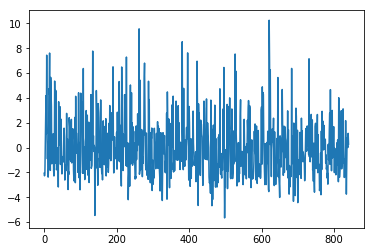

In [122]:
plt.plot(pca_data[:,0])

In [123]:
date_rng = pd.date_range(start='1/1/1946', end='2/1/2016', freq='M')

df = pd.DataFrame(date_rng, columns=['date'])

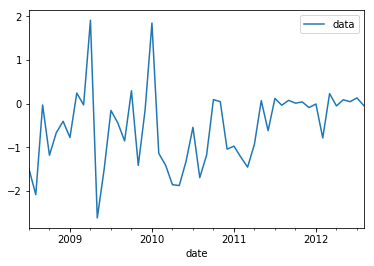

In [129]:
df["data"] = d[:,0]

df1 = df.iloc[750:800]

df1.plot(x="date", y="data")

In [71]:
df

,date,data
0,1946-01-31,4.936495
1,1946-02-28,4.598475
2,1946-03-31,1.793253
3,1946-04-30,-1.495814
4,1946-05-31,-2.674736
...,...,...
836,2015-09-30,-2.660799
837,2015-10-31,-0.816812
838,2015-11-30,1.752068
839,2015-12-31,2.805232


In [116]:
EPA[EPA.cc == 'ET']

,Unnamed: 0,i,j,lon,lat,meanRME,meanMAE,meanErrorRatio,cc
424,425,24,13,33.75,8.75,31.850611,22.880353,0.366920,ET
451,452,25,12,36.25,11.25,34.159342,22.874662,0.293333,ET
452,453,25,13,36.25,8.75,36.118614,26.682009,0.253463,ET
453,454,25,14,36.25,6.25,35.755215,28.347246,0.316693,ET
476,477,26,11,38.75,13.75,29.879503,19.729642,0.463286,ET
477,478,26,12,38.75,11.25,34.320965,24.991727,0.383437,ET
478,479,26,13,38.75,8.75,30.743257,23.448833,0.340393,ET
479,480,26,14,38.75,6.25,34.561373,25.917396,0.380613,ET
501,502,27,12,41.25,11.25,24.333323,18.140138,0.701340,ET
502,503,27,13,41.25,8.75,35.275413,26.690859,0.479326,ET


In [42]:
import reverse_geocode

In [43]:
reverse_geocode.search(coordinates)

TypeError: 'int' object is not iterable

In [15]:
APA.meanErrorRatio.max()

6.199005453200001

In [19]:
lon[21]

28.75

In [20]:
lat[7]

21.25

In [22]:
data[21,7,:]

array([2.000e-02, 2.000e-02, 1.000e-02, 0.000e+00, 1.000e-01, 0.000e+00,
       4.080e+00, 1.223e+01, 9.000e-02, 1.000e-01, 0.000e+00, 1.000e-02,
       2.000e-02, 2.000e-02, 1.000e-02, 0.000e+00, 1.000e-01, 0.000e+00,
       6.000e-02, 4.600e-01, 8.000e-02, 1.000e-01, 0.000e+00, 1.000e-02,
       2.000e-02, 2.000e-02, 1.000e-02, 0.000e+00, 1.000e-01, 0.000e+00,
       6.000e-02, 1.300e-01, 8.000e-02, 1.100e-01, 0.000e+00, 1.000e-02,
       2.000e-02, 2.000e-02, 1.000e-02, 0.000e+00, 4.500e-01, 0.000e+00,
       6.000e-02, 1.070e+00, 8.000e-02, 1.000e-01, 1.200e-01, 1.000e-02,
       2.000e-02, 2.000e-02, 1.000e-02, 0.000e+00, 1.000e-01, 0.000e+00,
       6.640e+00, 5.490e+00, 8.000e-02, 1.000e-01, 0.000e+00, 1.000e-02,
       2.000e-02, 2.000e-02, 1.000e-02, 0.000e+00, 1.000e-01, 0.000e+00,
       7.600e-01, 2.000e-02, 7.800e-01, 1.000e-01, 0.000e+00, 1.000e-02,
       2.000e-02, 2.000e-02, 1.000e-02, 0.000e+00, 1.000e-01, 0.000e+00,
       0.000e+00, 5.230e+00, 8.000e-02, 3.300e-01, 

Text(0.5,1,'Errors for Exponential Smoothing')

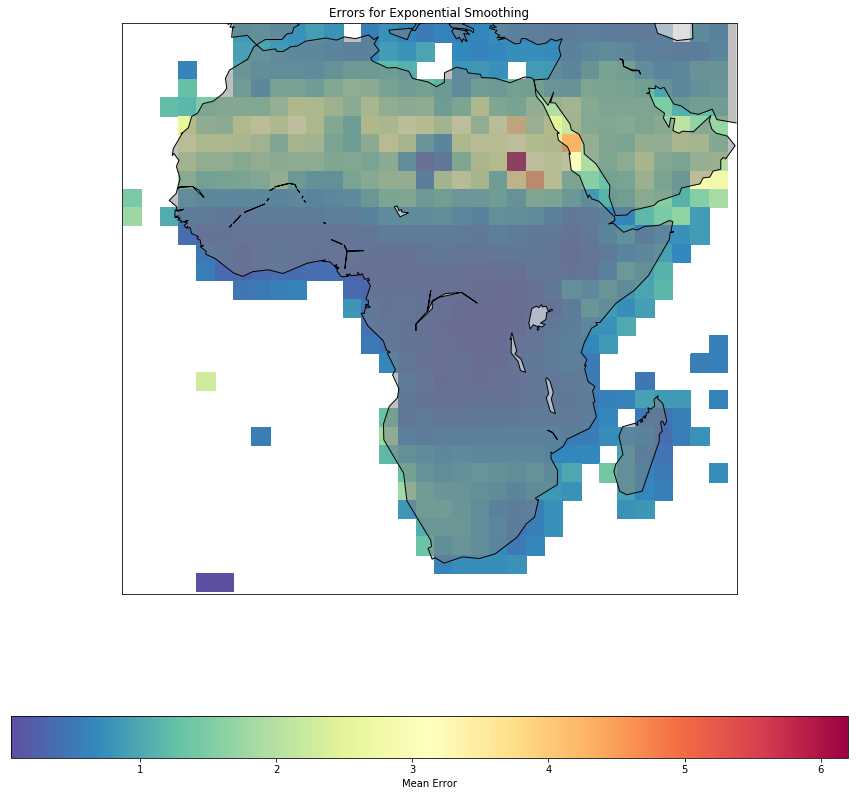

In [11]:
deg = np.zeros((len(lat),len(lon)))

for i in range(lat_number):
    for j in range(lon_number):
        if APA[(APA.lat == lat[i]) & (APA.lon == lon[j])].values.size != 0:
            deg[i,j] = APA[(APA.lat == lat[i]) & (APA.lon == lon[j])].meanErrorRatio.values
        else:
            deg[i,j]=np.nan

lon1 = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-39,urcrnrlon=60,urcrnrlat=39)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
xx, yy = meshgrid(lon1, lat)
cs = m.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label('Mean Error')
plt.title("Errors for Exponential Smoothing")

Text(0.5,1,'Errors for Exponential Smoothing + STL')

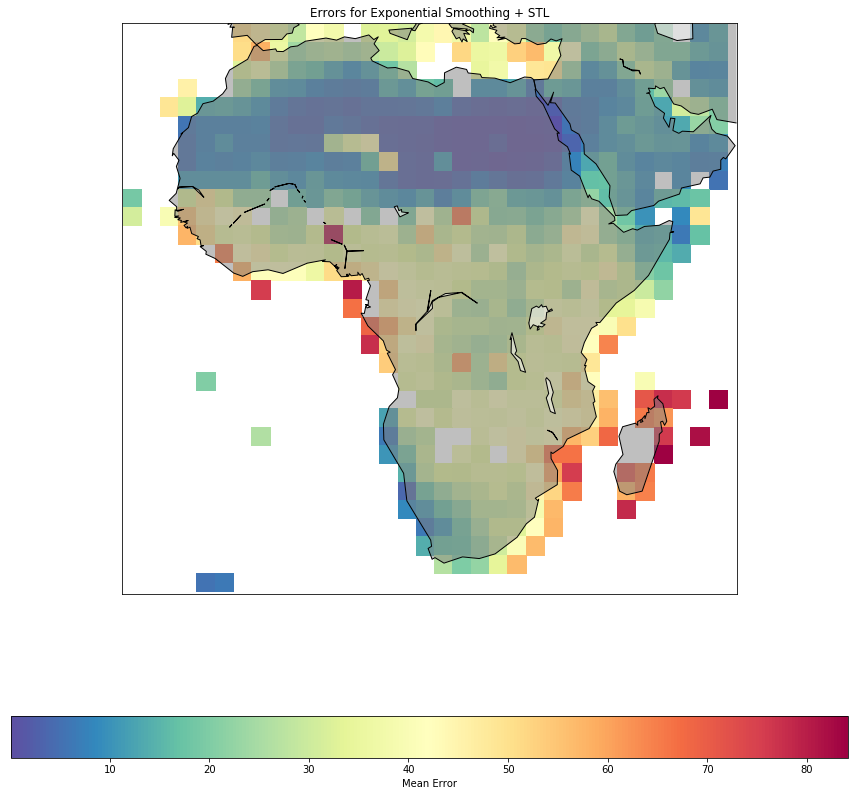

In [27]:
deg = np.zeros((len(lat),len(lon)))

for i in range(lat_number):
    for j in range(lon_number):
        if stl[(stl.lat == lat[i]) & (stl.lon == lon[j])].values.size != 0:
            deg[i,j] = stl[(stl.lat == lat[i]) & (stl.lon == lon[j])].meanError.values
        else:
            deg[i,j]=np.nan

lon1 = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-39,urcrnrlon=60,urcrnrlat=39)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
xx, yy = meshgrid(lon1, lat)
cs = m.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label('Mean Error')
plt.title("Errors for Exponential Smoothing + STL")

Text(0.5,1,'Errors for Neural Network')

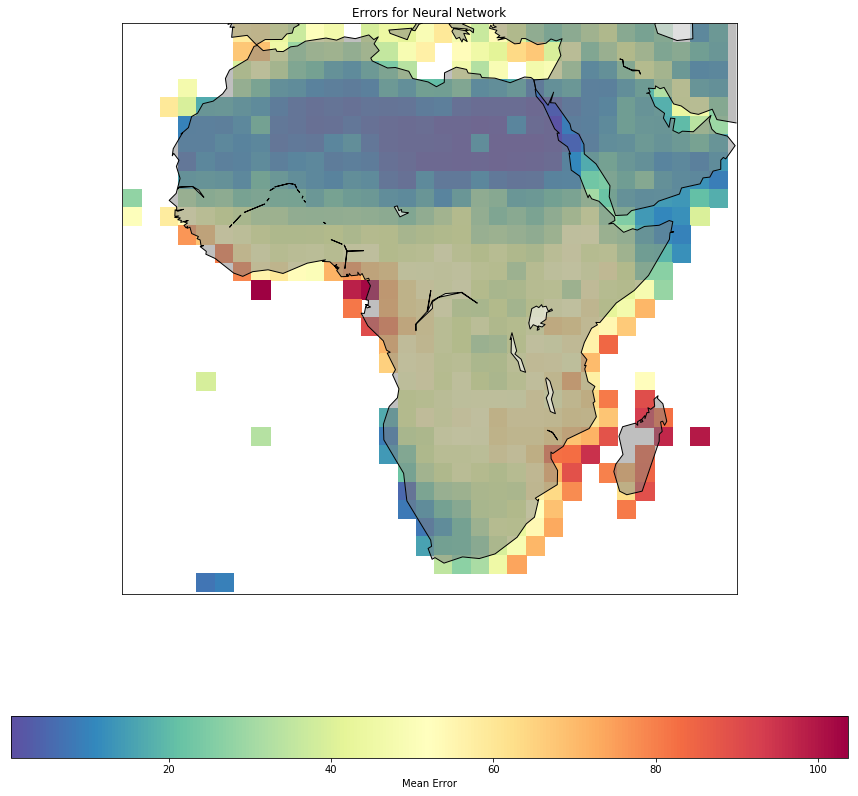

In [28]:
deg = np.zeros((len(lat),len(lon)))

for i in range(lat_number):
    for j in range(lon_number):
        if NN[(NN.lat == lat[i]) & (NN.lon == lon[j])].values.size != 0:
            deg[i,j] = NN[(NN.lat == lat[i]) & (NN.lon == lon[j])].meanError.values
        else:
            deg[i,j]=np.nan

lon1 = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-39,urcrnrlon=60,urcrnrlat=39)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
xx, yy = meshgrid(lon1, lat)
cs = m.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label('Mean Error')
plt.title("Errors for Neural Network")

Text(0.5,1,'Errors for auto.arima')

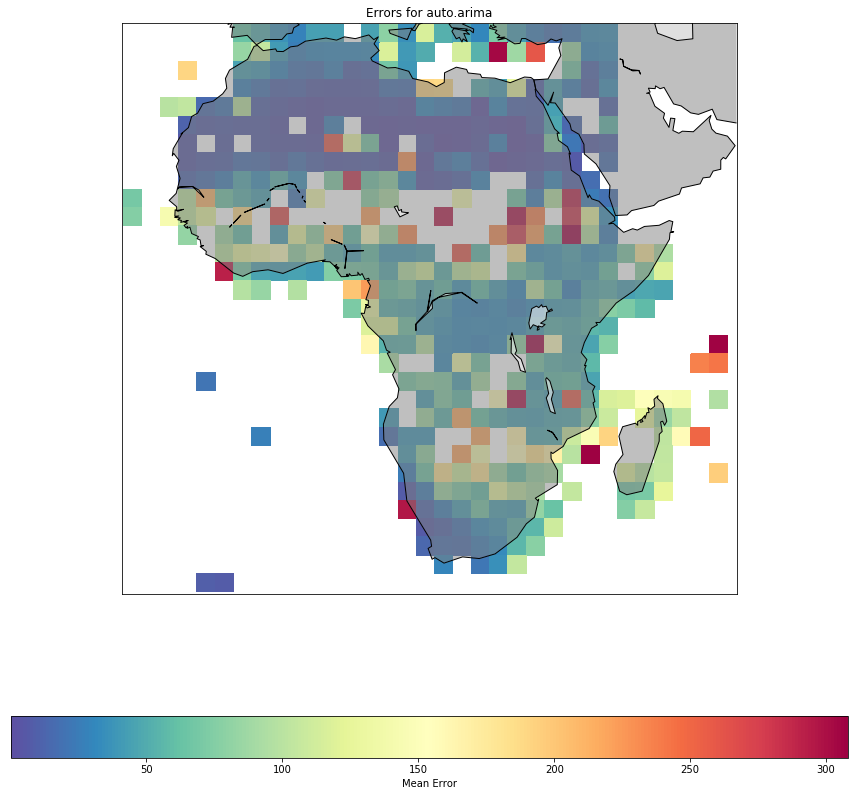

In [20]:
deg = np.zeros((len(lat),len(lon)))

for i in range(lat_number):
    for j in range(lon_number):
        if auto[(auto.lat == lat[i]) & (auto.lon == lon[j])].values.size != 0:
            deg[i,j] = auto[(auto.lat == lat[i]) & (auto.lon == lon[j])].meanError.values
        else:
            deg[i,j]=np.nan

lon1 = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-39,urcrnrlon=60,urcrnrlat=39)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
xx, yy = meshgrid(lon1, lat)
cs = m.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label('Mean Error')
plt.title("Errors for auto.arima")